In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

In [ ]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'image','*.png')
        self.mask_files = []
        for img_path in img_files:
             self.mask_files.append(os.path.join(folder_path,'mask',os.path.basename(img_path)) 

    def __getitem__(self, index):
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        data = use opencv or pil read image using img_path
        label =use opencv or pil read label  using mask_path
        return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))
        
    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class BayesUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True,Bayes=True,dropout_prob=.5):
        super(BayesUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = ConvBlock(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
         
        self.down3 = Down(256, 512)
        
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        self.aleatoric = OutConv(64, n_classes)
        if Bayes=True:
            self.dropout1 = nn.Dropout(dropout_prob)
            self.dropout2 = nn.Dropout(dropout_prob)
            self.dropout3 = nn.Dropout(dropout_prob)
            self.dropout4 = nn.Dropout(dropout_prob)
            self.dropout5 = nn.Dropout(dropout_prob)
            self.dropout6 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        x3 = self.dropout1(x3)
        x4 = self.down3(x3)
        
        x4 = self.dropout2(x4)
        x5 = self.down4(x4)
        
        x5 = self.dropout3(x5)
        x = self.up1(x5, x4)
        
        x = self.dropout4(x)
        x = self.up2(x, x3)
        
        x = self.dropout5(x)
        x = self.up3(x, x2)
        
        x = self.dropout6(x)
        x = self.up4(x, x1)
        
        logits = self.outc(x)
        uncertainty = self.aleatoric(x)
        return logits,uncertainty
    
    def train(x,y,epochs,loss):
        
        

In [ ]:
class Bayes_loss(nn.Module):
    def __init__(self,num_samples=10,num_classes=num_classes,weight=None,output_shape=(128,128)):
        super(Bayes_loss,self).__init__()
        self.num_samples=num_samples
        self.num_classes = num_classes
        self.weight = weight
        self.cross_entropy = nn.CrossEntropyLoss(weight)
        self.elu=nn.ELU()
        self.output_shape = output_shape
    
    def gaussian_cross_entropy(self,dist,outputs,targets,undistorted_loss,std):
        std_samples = dist.sample_n(self.num_classes)
        std_samples = std_samples.view(1,self.num_classes,self.output_shape[0],self.output_shape[1])
        std_samples =std*std_samples.type(torch.cuda.FloatTensor)
        temp = outputs + std_samples #.unsqueeze(0)
        distorted_loss = self.cross_entropy(temp, targets)
        diff = undistorted_loss - distorted_loss
        return -self.elu(diff)

    
    def forward(self,outputs,targets,log_var):
        variance=log_var
        std = torch.sqrt(variance+.0000001) #size 32 x 128 x 128
        variance_depressor = torch.exp(variance) - torch.ones_like(variance)
        variance_depressor = variance_depressor.view(1,-1)
        variance_depressor=torch.mean(variance_depressor) # scalar value
        
        undistorted_loss = self.cross_entropy(outputs,targets)

        mean=torch.zeros(self.output_shape[0],self.output_shape[1]).type(torch.cuda.FloatTensor)
        std1=torch.eye(self.output_shape[0],self.output_shape[1]).type(torch.cuda.FloatTensor)
        dist = MultivariateNormal(mean,std1)
        #dist = Normal(torch.zeros_like(std),std)
        #samples = dist.sample(12)
        mc_sample=0
        for i in range(self.num_samples):
            mc_sample =mc_sample+self.gaussian_cross_entropy(dist,outputs,targets,undistorted_loss,std)

        variance_loss = ((mc_sample/self.num_smaples) * undistorted_loss)
    
        return variance_loss+ undistorted_loss +variance_depressor

In [1]:
import pandas as pd
import numpy as np
import cv2
import os

In [2]:
images = os.listdir('CamVid/train/')
df = pd.read_csv('CamVid/camvid11.csv')

In [3]:
print(str('CamVid/train/'+images[0]))

CamVid/train/0016E5_04590.png


In [4]:
x = cv2.imread(str('CamVid/train_labels/'+images[0][:-4]+'_L.png'))

In [22]:
x.shape#bgr

(720, 960, 3)

In [ ]:
for img in images[:1]:
    img_path = str('CamVid/train/'+img)
    label_path = str('CamVid/train_labels/'+img[:-4]+'_L.png')
    mask_path = str('CamVid/train_mask/'+img)
    img = cv2.imread(img_path)
    label = cv2.imread(label_path)
    
    resize_img = cv2.resize(img, (256 , 256), cv2.INTER_NEAREST)
    resize_label = cv2.resize(label, (256 , 256), cv2.INTER_NEAREST)
    mask = convert_to_mask(resize_label,df)
    cv2.imwrite(mask_path, mask)

In [38]:
x.shape

(720, 960, 3)

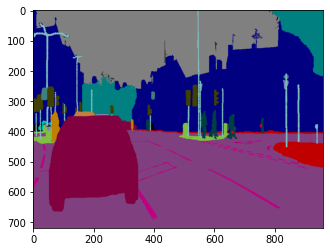

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(x)
plt.show()

In [44]:

def convert_to_mask(label,df):
    mask = np.zeros((256,256))
    for i in range(256):
        for j in range(256):
            for name in df['name']:
                r = int(df[df['name']==name]['r'])
                g = int(df[df['name']==name]['g'])
                b = int(df[df['name']==name]['b'])
                class_label = int(df[df['name']==name]['class'])
                if label[i,j,0]==b and label[i,j,1]==g and label[i,j,2]==r:
                    mask[i,j]= class_label
    return mask

IndexError: index 720 is out of bounds for axis 0 with size 720